In [1]:
#README
#before running the code, run a line with "startrow = 0", then delete it and run the whole code. Do this for every file of AFM data
#you have and it will keep saving the database in the same excel file. Once a certain sample is finished you can 
#change so that it creates a new excel file, then again run "startrow = 0" and start with the next sample.
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #plotting
from scipy.stats import iqr
from skimage.measure import label,regionprops
import stumpy
from scipy.signal import argrelmin
from skimage.transform import resize
from scipy.signal import find_peaks
#line below is 'magic (%)' and makes the plots appear inside this browser document
%matplotlib inline

In [7]:
file = r"U:\cleanroom\afm\characterization of patterns\patterns from 04.25\azo 5%\43 (R) 47 (L)\488_4x200_H_bi_dosetest_time_43_7.5s_15s_30s_45s_60s_47.txt"
data=[] 
info_file=r"U:\cleanroom\afm\characterization of patterns\patterns from 04.25\azo 5%\43 (R) 47 (L)\488_4x200_H_bi_dosetest_time_43_7.5s_15s_30s_45s_60s_47.flt"
info=[] 
with open(file,'rb') as f: 
    data=f.readlines() 
with open(info_file,'rb') as f: 
    info=f.readlines()

path_exc = r"U:\cleanroom\afm\results\azo_PEDOT_1%_DBSA.xlsx"
image_name="4x200_bi_488_15%_30s_distancetest_1_4um_2um_1um_4" #the code above is to open the data file and the info files with the specifics about the AFM image


In [8]:
data_points=np.asarray( list( map(float,data[1:])) )
data_points=data_points[::-1]
for line in info:
    if 'ResolutionX' in str(line):
        res_x=int(str(line).split('=')[1].split('\\')[0])
    if 'ResolutionY' in str(line):
        res_y=int(str(line).split('=')[1].split('\\')[0])
    if 'ScanRangeX' in str(line):
        rangex=float(str(line).split('=')[1].split('\\')[0])
    if 'ScanRangeY' in str(line):
        rangey=float(str(line).split('=')[1].split('\\')[0])
pixel_x_nm=rangex*1000/res_x
pixel_y_nm=rangey*1000/res_y
data_points
#The code above is used to extrapolate the values of resolution and scan range in X and Y direction and then compute the pixel size 
#so it works also for different size and scan freq images!

array([-216.8296 , -182.293  , -147.3073 , ..., -191.2197 ,   42.48325,
         56.26565])

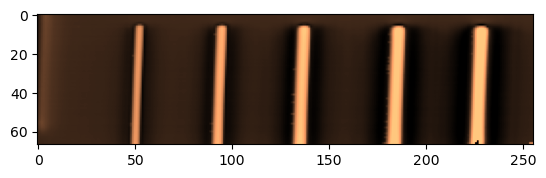

In [13]:

img=data_points.reshape(res_y,res_x)#[::-1]

min_val_color = np.min(data_points)+iqr(data_points,rng=(0,2)) #cut out super dark pixels
max_val_color = np.min(data_points)+iqr(data_points,rng=(0,98)) #cut out super bright pixels
#the color scale now represents the 1-99 percentile values, making it more contrasted
#plt.imshow(img,cmap='copper',vmin=min_val_color,vmax=max_val_color)
#fig,ax=plt.subplots(1,2,figsize=(8,4))
plt.imshow(img,cmap='copper',vmin=min_val_color,vmax=max_val_color)
plt.savefig('Drawing1.png',format='png', dpi=300)
#ax[1].imshow(img<min_val_color)
#the code above is used to image the data getting rid of too high and too low values in order to have better contrast

In [14]:
#
#
#
n_maxima = 5
#
#
#

In [15]:
regs=regionprops(label(img<min_val_color))
region=regs[np.argsort([r.area for r in regs])[-1]] #largest feature\
orientation=region.orientation
orientation=0
#this is made to save the orientation of the biggest connected feature

In [20]:
def extract_line_data(orientation,img,offset,plot=True):
    m=np.tan(-orientation)

    x=np.arange(img.shape[1])

    
    ind_line=np.clip(0,img.shape[1]-1,np.vstack((m*x+offset,x)).astype(int)).T
   
    check = img.copy()
    check[ind_line[:,0],ind_line[:,1]]=np.max(img)
    const=img.shape[0]//(2*10)
    if plot==True:
        #fig,ax=plt.subplots(1,2,figsize=(8,4))
    
        for c in range(img.shape[0]//4,3*img.shape[0]//4,const):
            plt.plot(m*x+c)
            plt.imshow(img,cmap='copper',vmin=min_val_color,vmax=max_val_color)   

        #plt.imshow(check)
    plt.savefig('Drawing2.png',format='png', dpi=300)
    return img[ind_line[:,0],ind_line[:,1]]
#extract_line_data(orientation,img,offset=50)


536

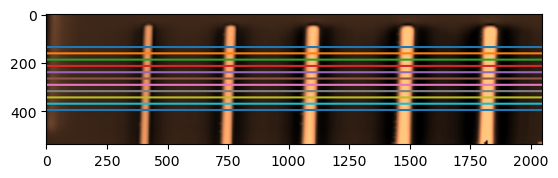

In [21]:
#resize_size=1024

remapped_img=resize(img,(res_y*8,res_x*8))

extract_line_data(orientation,remapped_img,offset=300)
remapped_img.shape[0]
#this is just to resize the image to 1024x1024 points by using interpolation

In [22]:
const=res_y*8//(2*10.5)
profiles=[extract_line_data(orientation,remapped_img,offset,False) for offset in np.arange(res_y*8//4,3*res_y*8//4,const)]
profiles=[p-np.mean(p) for p in profiles] 
len(profiles)
# use extract_line_data to get the profiles and then center them aroun 0

11

<Figure size 640x480 with 0 Axes>

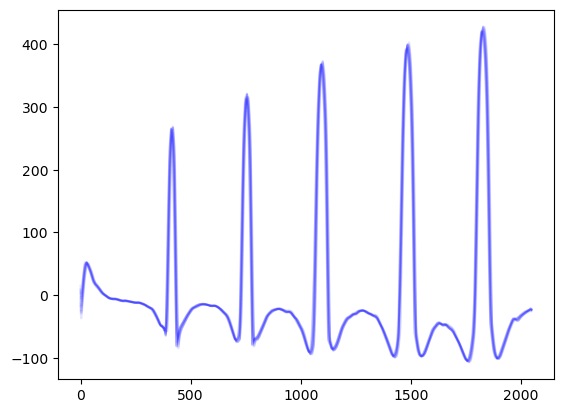

In [28]:
for p in profiles:
    plt.plot(p,alpha=.1,color='b')
plt.savefig('Cross_sections.png',format='png', dpi=300)

In [29]:
from scipy.signal import fftconvolve
realign_shift=[]
for i in range(len(profiles)-1):
    shift=np.argmax(fftconvolve(profiles[i],profiles[i+1][::-1]))-len(profiles[i])
    realign_shift.append(shift)
realign_shift=np.cumsum(np.hstack((0,realign_shift)))

#This code is used to obtain the shifts to realign the profiles

In [30]:
#aligned_profiles=profiles

In [31]:
aligned_profiles=[np.roll(profiles[i],realign_shift[i]) for i in range(len(realign_shift))]

#this code is used to align the profiles

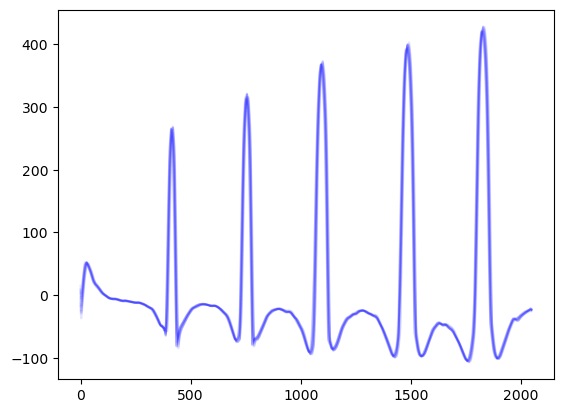

In [32]:
for ap in aligned_profiles:
    plt.plot(ap,alpha=.1,color='b')

In [33]:
aligned_profiles=np.asarray(aligned_profiles)
med=np.median(aligned_profiles,axis=0)
dev=np.median(np.abs(aligned_profiles-np.mean(aligned_profiles,axis=0)),axis=0)/0.675

#calculates median and standard deviation of the plots to determine the median one and an area around representing the error?
#we devide by 0.675 because we are looking into the median absolute deviation and then normalize it assuming normal distribution

In [34]:
aligned_profiles=np.asarray(aligned_profiles)

mean=np.mean(aligned_profiles,axis=0)
std=np.std(aligned_profiles,axis=0)

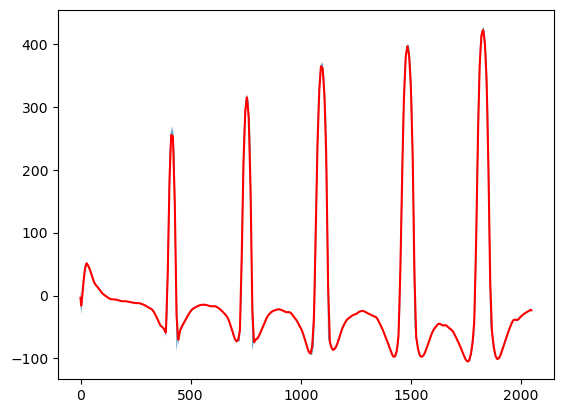

In [35]:
plt.fill_between(np.arange(len(mean)),mean-std,mean+std,alpha=.7)
plt.plot(mean,color='r')

In [36]:
peaks,infodict=find_peaks(med,height=20,width=[10,1000])
true_peaks=peaks[np.argsort(infodict['prominences'])[::-1][:n_maxima]]
true_peaks
#this code is made to find the peaks, but only those within a certain width are selected. so i can calculate their width with the function?
#then the peaks are sorted by peak height

array([1827, 1484, 1092,  756,  412], dtype=int64)

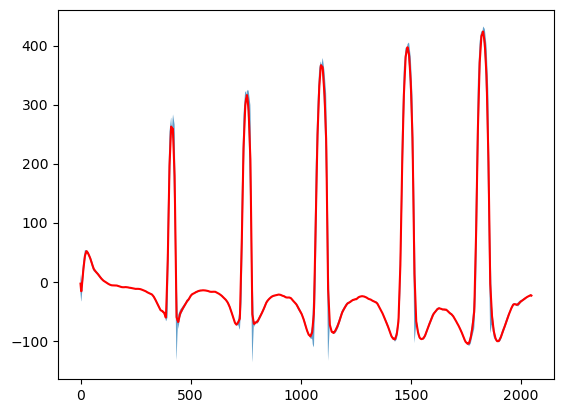

In [37]:
plt.fill_between(np.arange(len(med)),med-dev,med+dev,alpha=.7)
plt.plot(med,color='r')

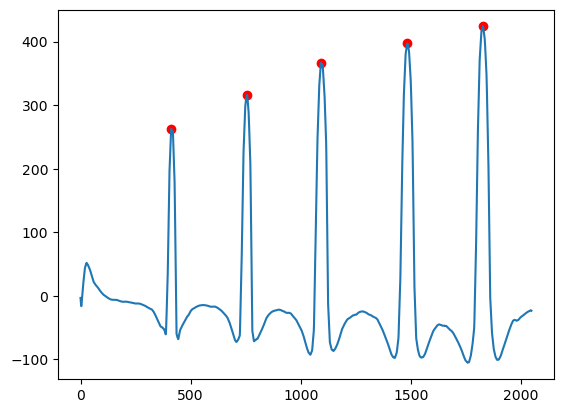

In [39]:
plt.plot(true_peaks,med[true_peaks],'o',color='r')
plt.plot(med)
plt.savefig('mxima_detected.png',format='png', dpi=300)

In [170]:
true_peaks.sort()
#to sort from the left to right the peaks we encounter
maxima_med=med[true_peaks]
maxima_dev=dev[true_peaks]
true_peaks

array([ 622,  944, 2085, 2215, 3550], dtype=int64)

In [179]:
from scipy.signal import peak_widths
width=np.zeros((len(aligned_profiles),n_maxima))
heights=np.zeros((len(aligned_profiles),n_maxima))

for i in range(len(aligned_profiles)):
    maxima,infodict_m=find_peaks(aligned_profiles[i],height=19,distance=None,prominence=None,width=[0,10000]) #find position of maxima and dict values
    
    true_maxima=maxima[np.argsort(infodict_m['prominences'])[::-1][:n_maxima]]
    true_maxima.sort()
    print(true_maxima)
    #heights[i]=infodict_m['peak_heights'] #asign teh prominence of the peaks to the height value
    
    widths,width_heights,left_ips, right_ips = peak_widths(aligned_profiles[i],true_maxima,rel_height=1,wlen=243)
    for m in range(len(true_maxima)):
        heights[i,m]=aligned_profiles[i][true_maxima[m]]-width_heights[m]
        width[i,m]=widths[m]*(pixel_x_nm/8)

heights
#width_heights[1]

#aligned_profiles[10][true_maxima[1]]

[ 620  940 2076 3555]
[ 629  949 2085 2502 3550]
[ 626  946 2083 3554 3858]
[ 622  942 2079 2215 3550]
[ 619  939 2075 2211 3547]
[ 617  937 2080 2217 3552]
[ 615  942 2079 2214 3543]
[ 622  942 2079 2214 3543]
[ 623  943 2087 3319 3536]
[ 631  944 2087 2223 3543]
[ 631  951 2087 3543 3855]


array([[156.61786891, 196.69934398, 164.27148281, 295.14144258,
          0.        ],
       [149.29575191, 187.38418926, 134.76633491,  20.89910391,
        256.52104691],
       [145.03242812, 184.27331533, 109.93610021, 239.59612051,
         22.37843477],
       [142.11431859, 188.98974133,  92.90646616,  14.01781465,
        256.07099758],
       [138.44333047, 183.61713466,  88.2227902 ,  15.0995052 ,
        266.53168789],
       [137.15412535, 183.62422172,  93.33126086,  19.58545785,
        260.27621836],
       [139.27572664, 187.08020573,  99.62083879,  15.24811414,
        257.08114125],
       [139.14451191, 187.87454397,  98.13970539,   7.19162898,
        221.15497461],
       [135.35928699, 183.09122501, 104.10094023,  18.51855   ,
        186.92086023],
       [139.68843242, 186.85035145, 112.87521527,   3.33380996,
        127.7247634 ],
       [139.08767371, 185.08581225, 112.44882531,  82.11755488,
         14.14980352]])

In [180]:
med_width=np.median(width, axis=0)
std_width=np.median(np.abs(width-np.mean(width,axis=0)),axis=0)/0.675 
med_height=np.median(heights, axis=0)
std_height=np.median(np.abs(heights-np.mean(heights,axis=0)),axis=0)/0.675

In [181]:
#database=np.concatenate((np.matrix(maxima_med).T,np.matrix(maxima_dev).T,np.matrix(med_width).T,np.matrix(std_width).T,np.matrix(image_details).T), axis=1)
#atabase
image_details=list(range(1,n_maxima+1))

database=np.concatenate((np.matrix(image_details).T,np.matrix(med_width).T,np.matrix(std_width).T,np.matrix(med_height).T,np.matrix(std_height).T,np.matrix(heights).T,np.matrix(image_details).T,np.matrix(width).T,np.matrix(image_details).T), axis=1)
database=np.around(database,decimals=1)
database

array([[1.0000e+00, 2.8458e+03, 5.9400e+01, 1.3930e+02, 4.6000e+00,
        1.5660e+02, 1.4930e+02, 1.4500e+02, 1.4210e+02, 1.3840e+02,
        1.3720e+02, 1.3930e+02, 1.3910e+02, 1.3540e+02, 1.3970e+02,
        1.3910e+02, 1.0000e+00, 2.9034e+03, 2.8422e+03, 2.8458e+03,
        2.9128e+03, 2.8815e+03, 2.8990e+03, 2.9377e+03, 2.8405e+03,
        2.8115e+03, 2.8227e+03, 2.7941e+03, 1.0000e+00],
       [2.0000e+00, 2.6290e+03, 4.5400e+01, 1.8690e+02, 3.3000e+00,
        1.9670e+02, 1.8740e+02, 1.8430e+02, 1.8900e+02, 1.8360e+02,
        1.8360e+02, 1.8710e+02, 1.8790e+02, 1.8310e+02, 1.8690e+02,
        1.8510e+02, 2.0000e+00, 2.6114e+03, 2.6137e+03, 2.6359e+03,
        2.6290e+03, 2.5898e+03, 2.8632e+03, 2.6665e+03, 2.6308e+03,
        2.5971e+03, 2.5829e+03, 2.6672e+03, 2.0000e+00],
       [3.0000e+00, 1.9628e+03, 2.3590e+02, 1.0410e+02, 1.7700e+01,
        1.6430e+02, 1.3480e+02, 1.0990e+02, 9.2900e+01, 8.8200e+01,
        9.3300e+01, 9.9600e+01, 9.8100e+01, 1.0410e+02, 1.1290e+02,
  

In [182]:
sourceFile = openpyxl.load_workbook(path_exc)

maxRowSourceFile = sourceFile['Sheet1'].max_row
maxColSourceFile = sourceFile['Sheet1'].max_column
startrow=maxRowSourceFile

In [183]:

#in the next row you can add another column to specify the pattern analyzed in the image
workbook = openpyxl.load_workbook(path_exc)

# Select the worksheet to modify
worksheet = workbook['Sheet1']

startrow+=2
# Write a string to a specific cell in the given row (e.g. cell A3)
cell_address = f'A{startrow}'
worksheet[cell_address] = image_name
startrow+=1

# Save the changes to the Excel file
workbook.save(path_exc)
height_arr=['height'] * len(profiles)
width_arr=['width']* len(profiles)
height_arr=height_arr[::-1]
width_arr=width_arr[::-1]
df1 = pd.DataFrame(database);print(df1.shape)

dfs=[df1]

with pd.ExcelWriter(path_exc,mode='a',if_sheet_exists='overlay') as writer:
    for df in dfs:
        df.to_excel(writer, engine="xlsxwriter", startrow=startrow, index=False)
       
        

(5, 29)
